In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

import pprint
import csv
import ast
import re

In [2]:
import sparql_functions as spqf

In [16]:
header=["id_entity"]

In [21]:
df_COG= pd.read_csv("spreadsheets/continent_occ_gender.csv", sep="|", header=0)
df_OT= pd.read_csv("spreadsheets/occupation_type.csv", sep="|")


In [22]:
df_OT

,id_entity,occupation,type
0,urn:uuid:fb3527da-478c-4e4f-a861-9de00b9d154b,politician,economist
1,urn:uuid:9ce56c33-08da-497c-afb0-38cb6ff6536c,politician,jurist
2,urn:uuid:2178758f-d8df-447d-b64b-bd78dfe045b7,politician,economist
3,urn:uuid:490ab506-b377-4e39-bf39-3d6e3f732a62,politician,jurist
4,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,politician,jurist
...,...,...,...
50250,urn:uuid:372c7ece-72e9-41c2-85d5-a7db48416e0a,athlete,jurist
50251,urn:uuid:e84e1f97-1c70-484d-aefb-139000544115,athlete,jurist
50252,urn:uuid:637bdebc-2cdc-4d37-8d3d-65eb4207b6ea,athlete,jurist
50253,urn:uuid:259ef0ec-9d87-4d3c-bcb5-842110203f13,athlete,jurist


In [23]:
df_COG

,uri_entity,year,continent,occupation,gender
0,urn:uuid:fb3527da-478c-4e4f-a861-9de00b9d154b,1959,North Am.,economist,male
1,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male
2,urn:uuid:98651569-7301-4398-a760-bcb03931dc0f,1955,North Am.,jurist,male
3,urn:uuid:080c5cc7-c62c-46ec-b0e9-0b98b6adc235,1927,North Am.,economist,male
4,urn:uuid:f967d755-8e28-4729-9966-1aa3e0bdba98,1827,North Am.,jurist,male
...,...,...,...,...,...
108755,urn:uuid:281f347f-652c-4131-b901-99280b37484b,2000,Africa,economist,male
108756,urn:uuid:b3e926f4-c0dc-473e-82a4-b142f591fba1,1988,North Am.,jurist,male
108757,urn:uuid:26514901-ca29-42fd-84c1-fdf8ed8cc633,1944,Africa,jurist,male
108758,urn:uuid:89978157-3d82-47d1-817c-7fbe7729c52d,1956,Asia,jurist,female


In [24]:
df_COG=df_COG.rename(columns={"occupation": "type", "uri_entity":"id_entity"})

In [25]:
col=["id_entity", "type"]

In [26]:
df=pd.merge(df_COG, df_OT,on=col, how='inner', sort=False)
df

,id_entity,year,continent,type,gender,occupation
0,urn:uuid:fb3527da-478c-4e4f-a861-9de00b9d154b,1959,North Am.,economist,male,politician
1,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male,politician
2,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male,businessperson
3,urn:uuid:080c5cc7-c62c-46ec-b0e9-0b98b6adc235,1927,North Am.,economist,male,academic
4,urn:uuid:50628dbc-50cd-4fd7-93f6-a444c2dac636,1860,North Am.,jurist,male,academic
...,...,...,...,...,...,...
51162,urn:uuid:026dbf6f-43ad-44a9-8ba5-3fd0dba69f23,1965,Oceania,economist,male,politician
51163,urn:uuid:6c05d14d-4b18-4e88-b287-616154b070d4,1946,Oceania,jurist,male,politician
51164,urn:uuid:3562befa-695e-4565-a071-0db205314f58,1948,Africa,economist,male,politician
51165,urn:uuid:26514901-ca29-42fd-84c1-fdf8ed8cc633,1944,Africa,jurist,male,politician


In [28]:
df['occupation'].replace(["journalist"],'media person',inplace=True)
df['occupation'].replace(["scientist", "academic","social researcher"],'scientist',inplace=True)
df['occupation'].replace(["banker"],'businessperson',inplace=True)
#df['occupation'].replace(["writer"],'artist',inplace=True)
df['occupation'].replace(["religious", "artist", "soldier", "other_occ"],'other_occupation',inplace=True)


In [29]:
### Occupation-continent contingency table with totals

X = "occupation"
Y = "continent"

contingContOcc = df[[X,Y]].pivot_table(index=Y,columns=X,aggfunc=len, margins=True, margins_name='All*').fillna(0).astype(int) 
# Sort the values by the total to see better with the visualization
contingContOcc = contingContOcc.sort_values(by="All*")
# Drop the column "All",  otherwise it appears as the modality in the plot
contingContOcc= contingContOcc.loc[:,contingContOcc.columns!="All*"]
contingContOcc= contingContOcc.drop(['uncoded'])
contingContOcc

occupation,activist,athlete,businessperson,media person,other,other_occupation,politician,scientist,teacher,writer
continent,,,,,,,,,,
Central Am.,7,6,14,25,18,7,295,28,4,52
Oceania,9,32,42,36,80,34,393,112,3,47
Africa,50,6,103,35,37,23,720,129,7,64
Middle East,54,3,98,126,74,42,936,211,33,198
Asia,66,10,110,75,141,25,1655,391,25,177
South Am.,54,8,248,483,171,100,3211,568,93,543
North Am.,134,251,711,697,742,829,11056,1571,197,796
Europe,160,108,1005,1196,1178,443,9645,5802,387,1905
All*,534,424,2332,2676,2441,1503,27913,8812,749,3783


In [11]:
# change the number of individuals into a percentage
perc_contin_OC= contingContOcc.apply(lambda x: x*100/sum(x), axis=1)

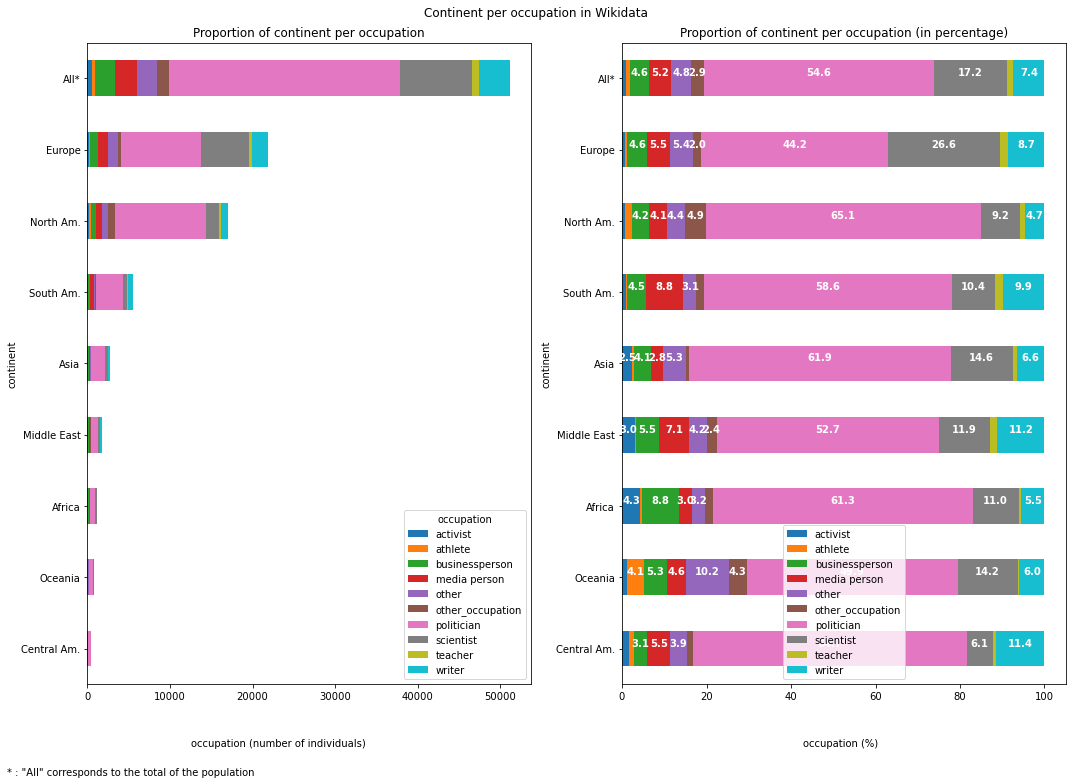

In [12]:
### create subplots side by side: 
# It is the best way, I found, but there are many other: cf. https://stackoverflow.com/questions/56121883/subplots-frequency-plots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
fig.suptitle('Continent per occupation in Wikidata')
contingContOcc.plot( kind='barh', stacked=True, ax=ax1, title="Proportion of continent per occupation")
z_CO=perc_contin_OC.plot(kind="barh", stacked=True, ax=ax2, title="Proportion of continent per occupation (in percentage)")
plt.tight_layout()

# Set labels and legends: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html

fig.text(0.747, -0.05, 'occupation (%)', ha='left', va='bottom')
fig.text(0.180, -0.05, 'occupation (number of individuals)', ha='left', va='bottom')
fig.text(0.01, -0.09, '* : "All" corresponds to the total of the population', ha='left', va='bottom')

#  Add percentages on the right plot: cf. https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
### drop the values inferior to: https://stackoverflow.com/questions/54682665/hide-matplot-annotation-if-value-is-0 

for p in z_CO.patches:
    left, bottom, width, height = p.get_bbox().bounds
    if width >= 2:
        z_CO.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

plt.legend(loc='lower center')
plt.show()

In [13]:
#Check the data type of year
print(df.dtypes)
min(df['year']), max(df['year'])

id_entity     object
year           int64
continent     object
type          object
gender        object
occupation    object
dtype: object


(1770, 2000)

In [14]:
# Create a list of generation (twenty years) periods
d20List = []
period = 20
d_start = 1771
i = 0
d20List.append(d_start)

while i < 11:
    d_start = d_start + period
    d20List.append(d_start)
    i += 1

In [15]:
# Copy the dataframe for do not work on it.
df_generation = df.copy(deep=True)
# Keep only the people born before 1950 (because as we can see above the number of individuals after 1950 decreases strongly,
# it is very probably a biais on the datas does not enter in Wikidata yet)
df_generation= df_generation[df_generation["year"]<=1950]
# add a column and cut individuals by their date of birth with the list just above.
df_generation['generation'] = pd.cut(df_generation['year'], d20List, right=False)

In [16]:
df_generation

,id_entity,year,continent,type,gender,occupation,generation
1,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male,politician,"[1911, 1931)"
2,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male,businessperson,"[1911, 1931)"
3,urn:uuid:080c5cc7-c62c-46ec-b0e9-0b98b6adc235,1927,North Am.,economist,male,scientist,"[1911, 1931)"
4,urn:uuid:50628dbc-50cd-4fd7-93f6-a444c2dac636,1860,North Am.,jurist,male,scientist,"[1851, 1871)"
5,urn:uuid:d5e86bba-4821-421e-9706-438a58c978a3,1873,North Am.,jurist,male,scientist,"[1871, 1891)"
...,...,...,...,...,...,...,...
51159,urn:uuid:52bf5716-a5fb-4de2-b167-35234aa928a1,1865,Asia,jurist,male,politician,"[1851, 1871)"
51163,urn:uuid:6c05d14d-4b18-4e88-b287-616154b070d4,1946,Oceania,jurist,male,politician,"[1931, 1951)"
51164,urn:uuid:3562befa-695e-4565-a071-0db205314f58,1948,Africa,economist,male,politician,"[1931, 1951)"
51165,urn:uuid:26514901-ca29-42fd-84c1-fdf8ed8cc633,1944,Africa,jurist,male,politician,"[1931, 1951)"


In [17]:
# improve the code by changing it to "YYYY-YYYY" format
df_generation['generation'] = df_generation['generation'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))


In [18]:
df_generation

,id_entity,year,continent,type,gender,occupation,generation
1,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male,politician,1911-1931
2,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male,businessperson,1911-1931
3,urn:uuid:080c5cc7-c62c-46ec-b0e9-0b98b6adc235,1927,North Am.,economist,male,scientist,1911-1931
4,urn:uuid:50628dbc-50cd-4fd7-93f6-a444c2dac636,1860,North Am.,jurist,male,scientist,1851-1871
5,urn:uuid:d5e86bba-4821-421e-9706-438a58c978a3,1873,North Am.,jurist,male,scientist,1871-1891
...,...,...,...,...,...,...,...
51159,urn:uuid:52bf5716-a5fb-4de2-b167-35234aa928a1,1865,Asia,jurist,male,politician,1851-1871
51163,urn:uuid:6c05d14d-4b18-4e88-b287-616154b070d4,1946,Oceania,jurist,male,politician,1931-1951
51164,urn:uuid:3562befa-695e-4565-a071-0db205314f58,1948,Africa,economist,male,politician,1931-1951
51165,urn:uuid:26514901-ca29-42fd-84c1-fdf8ed8cc633,1944,Africa,jurist,male,politician,1931-1951


In [19]:
# Construct a dateframe with the number of individuals by generation
pt_generation = pd.pivot_table(df_generation, index=['generation'], values='year', aggfunc=len,fill_value=0)
print(type(pt_generation))
pt_generation

<class 'pandas.core.frame.DataFrame'>


,year
generation,
1771-1791,929
1791-1811,1585
1811-1831,2399
1831-1851,2751
1851-1871,3819
1871-1891,4665
1891-1911,4844
1911-1931,6156
1931-1951,9913


In [20]:
### Generation-occupation Contingency table

X = "generation"  
Y = "occupation"

generation_occupation = df_generation[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
generation_occupation



occupation,activist,athlete,businessperson,media person,other,other_occupation,politician,scientist,teacher,writer
generation,,,,,,,,,,
1771-1791,1,2,14,29,66,31,631,91,5,59
1791-1811,0,2,22,69,99,35,1042,202,11,103
1811-1831,5,7,45,142,127,125,1486,269,28,165
1831-1851,4,14,69,166,127,93,1703,335,42,198
1851-1871,13,37,100,242,180,66,2328,464,72,317
1871-1891,30,86,138,310,229,112,2703,600,75,382
1891-1911,29,65,150,272,273,202,2516,817,101,419
1911-1931,56,48,254,287,269,345,3121,1129,102,545
1931-1951,98,76,568,435,425,233,4866,2327,145,740


In [21]:
# change the number of individuals into a percentage
perc_contin = generation_occupation.apply(lambda x: x*100/sum(x), axis=1)

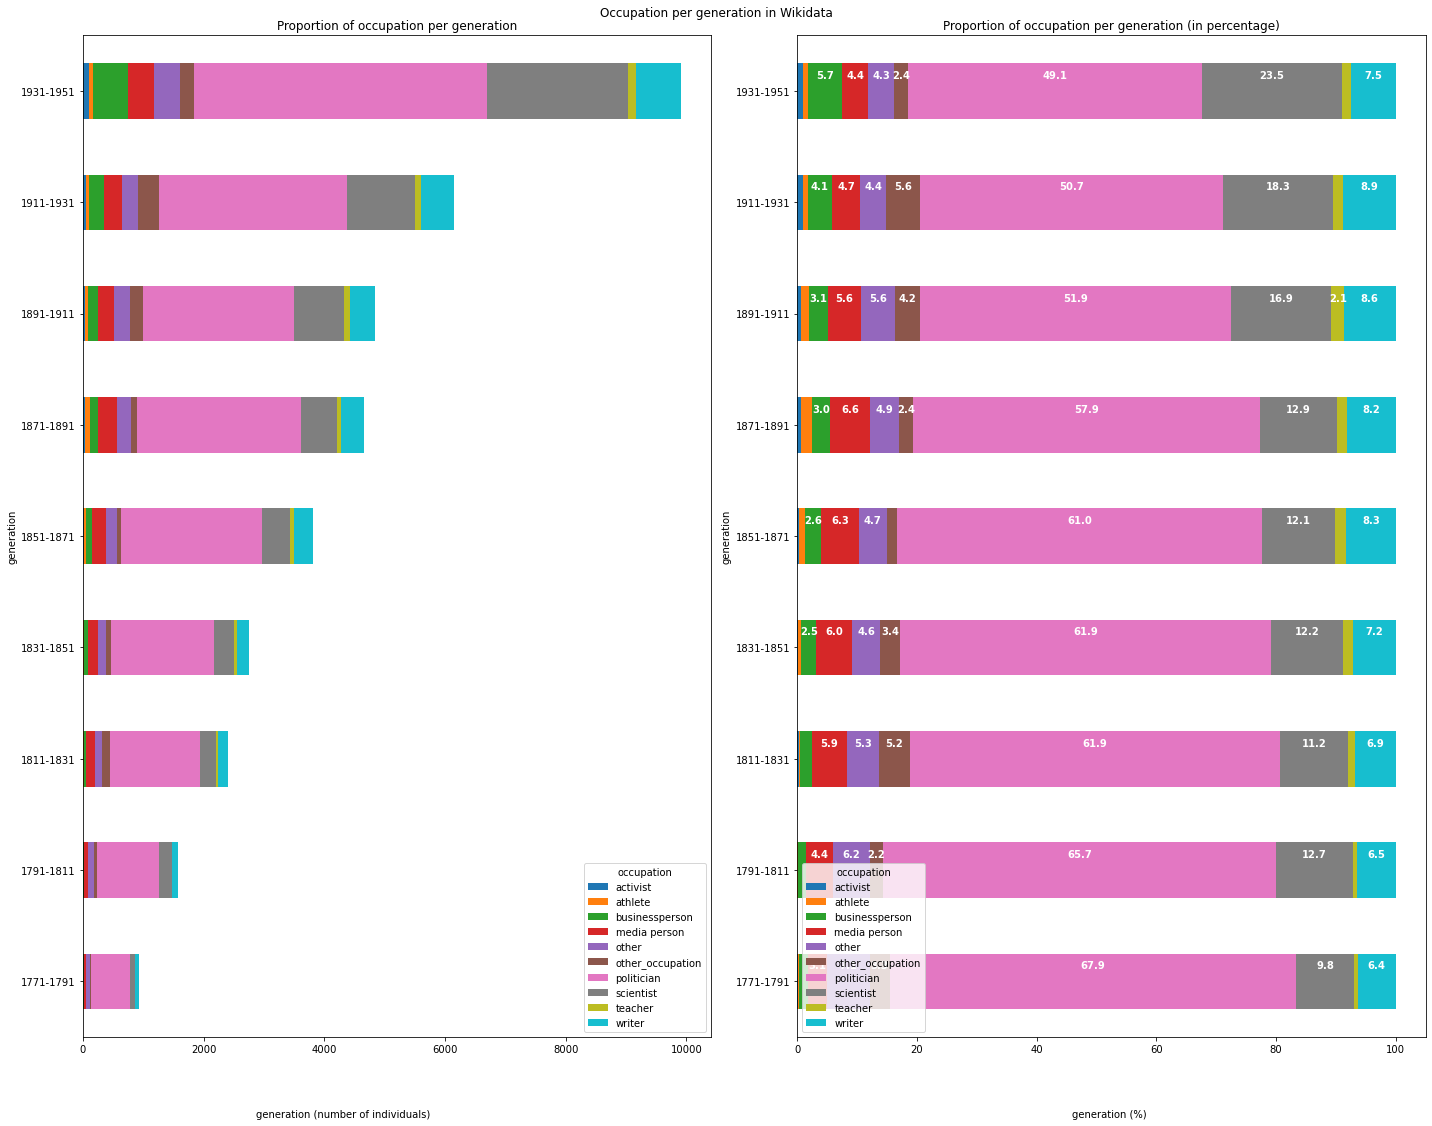

In [22]:
# create subplots side by side:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
fig.suptitle('Occupation per generation in Wikidata')
generation_occupation.plot( kind='barh', stacked=True, ax=ax1, title="Proportion of occupation per generation")
z_cont=perc_contin.plot(kind="barh", stacked=True, ax=ax2, title="Proportion of occupation per generation (in percentage)")
plt.tight_layout()

# Set labels and legends

fig.text(0.747, -0.05, 'generation (%)', ha='left', va='bottom')
fig.text(0.180, -0.05, 'generation (number of individuals)', ha='left', va='bottom')

#  Add percentages on the right plot: 

for p in z_cont.patches:
    left, bottom, width, height = p.get_bbox().bounds
    if width >= 2:
        z_cont.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax1.legend( title= "occupation", loc='lower right')
ax2.legend( title= "occupation",loc='lower left')

plt.show()

In [23]:
europe=pd.read_csv("spreadsheets/europe_indi.csv", sep="|")
europe= europe.rename(columns={"occupation": "type", "uri_entity":"id_entity"})

In [24]:
df_generation

,id_entity,year,continent,type,gender,occupation,generation
1,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male,politician,1911-1931
2,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,North Am.,jurist,male,businessperson,1911-1931
3,urn:uuid:080c5cc7-c62c-46ec-b0e9-0b98b6adc235,1927,North Am.,economist,male,scientist,1911-1931
4,urn:uuid:50628dbc-50cd-4fd7-93f6-a444c2dac636,1860,North Am.,jurist,male,scientist,1851-1871
5,urn:uuid:d5e86bba-4821-421e-9706-438a58c978a3,1873,North Am.,jurist,male,scientist,1871-1891
...,...,...,...,...,...,...,...
51159,urn:uuid:52bf5716-a5fb-4de2-b167-35234aa928a1,1865,Asia,jurist,male,politician,1851-1871
51163,urn:uuid:6c05d14d-4b18-4e88-b287-616154b070d4,1946,Oceania,jurist,male,politician,1931-1951
51164,urn:uuid:3562befa-695e-4565-a071-0db205314f58,1948,Africa,economist,male,politician,1931-1951
51165,urn:uuid:26514901-ca29-42fd-84c1-fdf8ed8cc633,1944,Africa,jurist,male,politician,1931-1951


In [25]:
col=["id_entity", "year","type","gender"]

In [26]:
merged_euro= pd.merge(df_generation,europe,on=col, sort=False)
merged_euro

,id_entity,year,continent,type,gender,occupation,generation,region
0,urn:uuid:eabd8139-89e4-4040-9bd4-ffd2a71713b5,1926,North Am.,economist,male,politician,1911-1931,Eastern Europe
1,urn:uuid:eabd8139-89e4-4040-9bd4-ffd2a71713b5,1926,Europe,economist,male,politician,1911-1931,Eastern Europe
2,urn:uuid:0de6c0dc-2e01-46ce-8826-841e6c7867b8,1899,North Am.,economist,male,scientist,1891-1911,Central Europe
3,urn:uuid:0de6c0dc-2e01-46ce-8826-841e6c7867b8,1899,Europe,economist,male,scientist,1891-1911,Central Europe
4,urn:uuid:ab1769f4-02ef-4923-b970-5ad678782682,1925,North Am.,jurist,male,scientist,1911-1931,Central Europe
...,...,...,...,...,...,...,...,...
16131,urn:uuid:b281f2b1-3f46-4cdf-95ae-c775098ae390,1936,Europe,jurist,male,businessperson,1931-1951,Southern Europe
16132,urn:uuid:c9f60a62-ea8f-44b4-9bff-569aca743a10,1943,Europe,economist,male,politician,1931-1951,Southern Europe
16133,urn:uuid:c80cc719-a929-4487-8256-e447145b625d,1941,Europe,jurist,male,writer,1931-1951,Southern Europe
16134,urn:uuid:c80cc719-a929-4487-8256-e447145b625d,1941,Europe,jurist,male,politician,1931-1951,Southern Europe


In [27]:
merged_euro=merged_euro[["id_entity","type","gender","occupation","generation","region"]].drop_duplicates()
merged_euro

,id_entity,type,gender,occupation,generation,region
0,urn:uuid:eabd8139-89e4-4040-9bd4-ffd2a71713b5,economist,male,politician,1911-1931,Eastern Europe
2,urn:uuid:0de6c0dc-2e01-46ce-8826-841e6c7867b8,economist,male,scientist,1891-1911,Central Europe
4,urn:uuid:ab1769f4-02ef-4923-b970-5ad678782682,jurist,male,scientist,1911-1931,Central Europe
6,urn:uuid:0139342c-3301-41e3-acf9-6f42dfd140a8,jurist,male,politician,1851-1871,British Isles
7,urn:uuid:0139342c-3301-41e3-acf9-6f42dfd140a8,jurist,male,media person,1851-1871,British Isles
...,...,...,...,...,...,...
16131,urn:uuid:b281f2b1-3f46-4cdf-95ae-c775098ae390,jurist,male,businessperson,1931-1951,Southern Europe
16132,urn:uuid:c9f60a62-ea8f-44b4-9bff-569aca743a10,economist,male,politician,1931-1951,Southern Europe
16133,urn:uuid:c80cc719-a929-4487-8256-e447145b625d,jurist,male,writer,1931-1951,Southern Europe
16134,urn:uuid:c80cc719-a929-4487-8256-e447145b625d,jurist,male,politician,1931-1951,Southern Europe


In [28]:
merged_euro['occupation'].replace(["journalist"],'media person',inplace=True)
merged_euro['occupation'].replace(["scientist", "academic","social researcher"],'scientist',inplace=True)
merged_euro['occupation'].replace(["banker"],'businessperson',inplace=True)
#df['occupation'].replace(["writer"],'artist',inplace=True)
merged_euro['occupation'].replace(["religious", "artist", "soldier", "other_occ"],'other_occupation',inplace=True)


In [29]:
### Generation-occupation Contingency table

X = "generation"  
Y = "occupation"

generation_occupation = merged_euro[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
generation_occupation



occupation,activist,athlete,businessperson,media person,other,other_occupation,politician,scientist,teacher,writer
generation,,,,,,,,,,
1771-1791,0,2,5,11,28,13,157,64,5,40
1791-1811,0,2,5,38,42,13,310,144,10,72
1811-1831,2,5,13,67,59,17,423,178,22,107
1831-1851,2,9,31,86,76,19,488,214,20,132
1851-1871,8,5,51,151,99,42,748,282,45,188
1871-1891,15,9,58,195,167,74,984,397,34,235
1891-1911,10,21,56,138,164,83,812,448,45,236
1911-1931,21,16,90,105,132,62,892,603,54,236
1931-1951,30,15,222,147,155,37,1716,1318,66,309


In [30]:
# change the number of individuals into a percentage
perc_contin = generation_occupation.apply(lambda x: x*100/sum(x), axis=1)

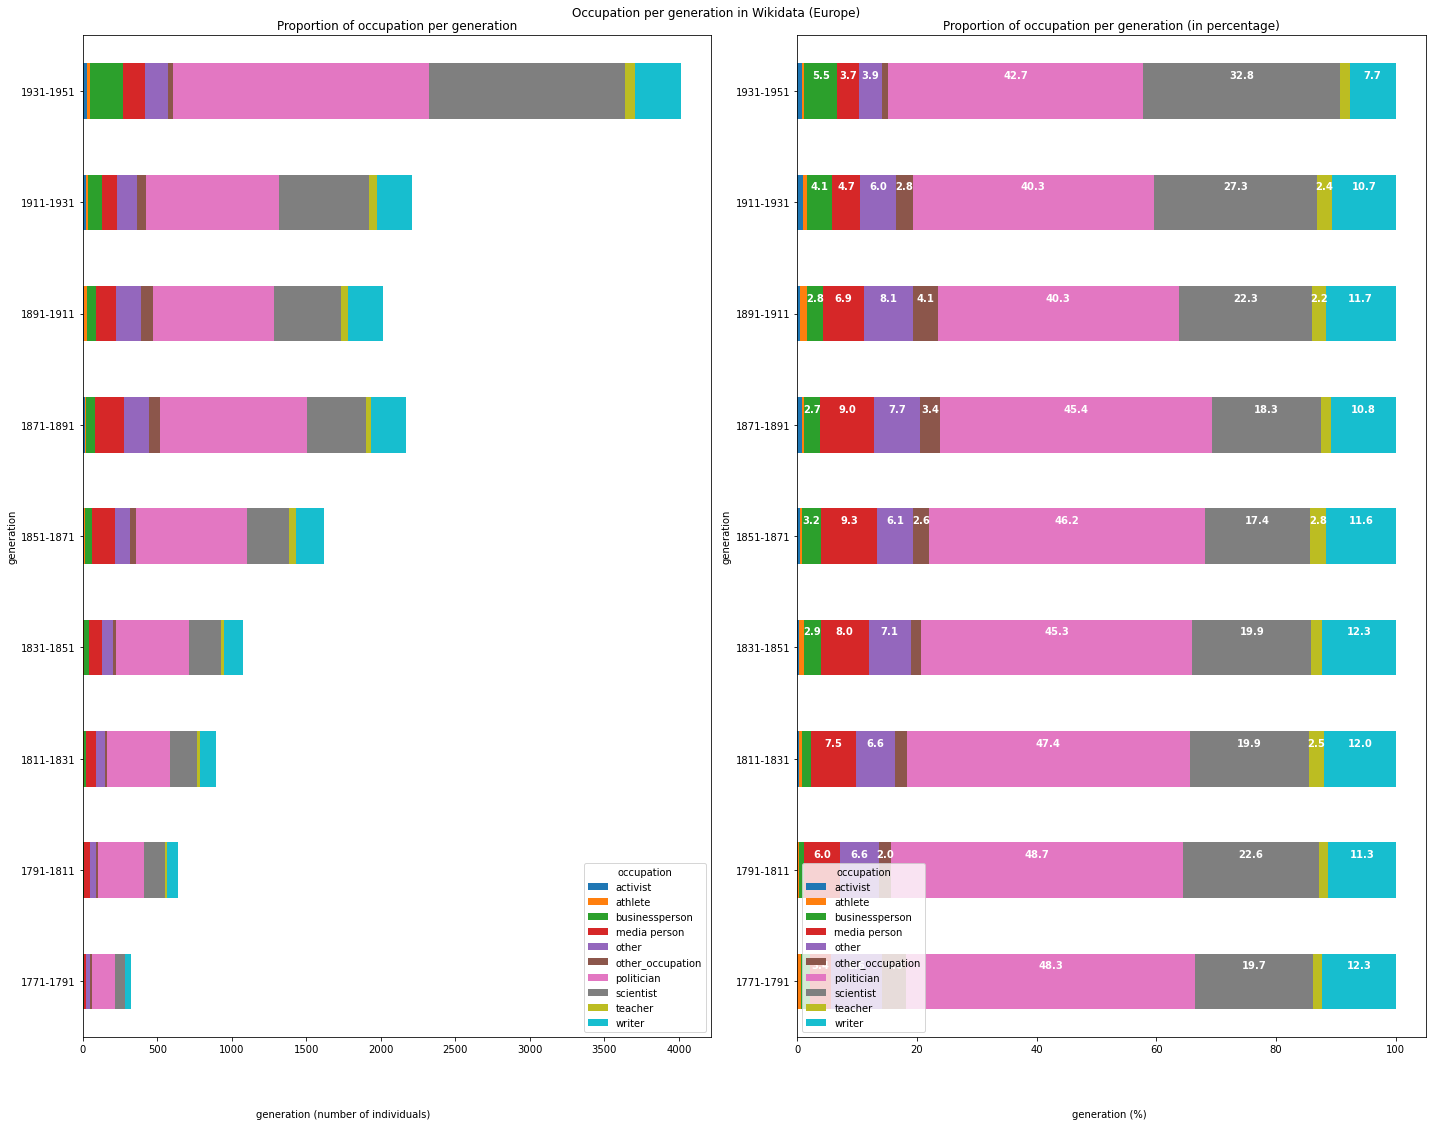

In [31]:
# create subplots side by side:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
fig.suptitle('Occupation per generation in Wikidata (Europe)')
generation_occupation.plot( kind='barh', stacked=True, ax=ax1, title="Proportion of occupation per generation")
z_cont=perc_contin.plot(kind="barh", stacked=True, ax=ax2, title="Proportion of occupation per generation (in percentage)")
plt.tight_layout()

# Set labels and legends

fig.text(0.747, -0.05, 'generation (%)', ha='left', va='bottom')
fig.text(0.180, -0.05, 'generation (number of individuals)', ha='left', va='bottom')

#  Add percentages on the right plot: 

for p in z_cont.patches:
    left, bottom, width, height = p.get_bbox().bounds
    if width >= 2:
        z_cont.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax1.legend( title= "occupation", loc='lower right')
ax2.legend( title= "occupation",loc='lower left')

plt.show()

In [9]:
from fanalysis.mca import MCA

In [38]:
merged_euro["generation"]=merged_euro["generation"].astype('object')
merged_euro=merged_euro.dropna()
print(merged_euro.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14957 entries, 0 to 16135
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_entity   14957 non-null  object
 1   type        14957 non-null  object
 2   gender      14957 non-null  object
 3   occupation  14957 non-null  object
 4   generation  14957 non-null  object
 5   region      14957 non-null  object
dtypes: object(6)
memory usage: 818.0+ KB
None


In [50]:
D=pd.read_csv('spreadsheets/europe_MCA.csv', header=0, index_col=0, sep="|")

In [51]:
print(D)

                                                    type gender  \
id_entity                                                         
urn:uuid:eabd8139-89e4-4040-9bd4-ffd2a71713b5  economist   male   
urn:uuid:0de6c0dc-2e01-46ce-8826-841e6c7867b8  economist   male   
urn:uuid:ab1769f4-02ef-4923-b970-5ad678782682     jurist   male   
urn:uuid:0139342c-3301-41e3-acf9-6f42dfd140a8     jurist   male   
urn:uuid:0139342c-3301-41e3-acf9-6f42dfd140a8     jurist   male   
...                                                  ...    ...   
urn:uuid:b281f2b1-3f46-4cdf-95ae-c775098ae390     jurist   male   
urn:uuid:c9f60a62-ea8f-44b4-9bff-569aca743a10  economist   male   
urn:uuid:c80cc719-a929-4487-8256-e447145b625d     jurist   male   
urn:uuid:c80cc719-a929-4487-8256-e447145b625d     jurist   male   
urn:uuid:9d74ae9a-ae54-4a11-92ed-827732ad7785     jurist   male   

                                                   occupation generation  \
id_entity                                           

In [23]:
cross=["+"]

In [25]:
D["cross"]="+"

In [52]:
D["generation"]=D["generation"].astype('object')
D=D.dropna()
print(D.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14957 entries, urn:uuid:eabd8139-89e4-4040-9bd4-ffd2a71713b5 to urn:uuid:9d74ae9a-ae54-4a11-92ed-827732ad7785
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   type        14957 non-null  object
 1   gender      14957 non-null  object
 2   occupation  14957 non-null  object
 3   generation  14957 non-null  object
 4   region      14957 non-null  object
dtypes: object(5)
memory usage: 701.1+ KB
None


In [53]:
X = D.iloc[:,0:6].to_numpy()
print(X)

[['economist' 'male' 'politician' '1911-1931' 'Eastern Europe']
 ['economist' 'male' 'scientist' '1891-1911' 'Central Europe']
 ['jurist' 'male' 'scientist' '1911-1931' 'Central Europe']
 ...
 ['jurist' 'male' 'writer' '1931-1951' 'Southern Europe']
 ['jurist' 'male' 'politician' '1931-1951' 'Southern Europe']
 ['jurist' 'male' 'writer' '1931-1951' 'Western Europe']]


In [58]:
my_mca = MCA(row_labels=None, var_labels=D.columns.values[0:6])
my_mca.fit(X)

MCA(var_labels=array(['type', 'gender', 'occupation', 'generation', 'region'],
      dtype=object))

In [59]:
print(my_mca.eig_)

[[  0.30314836   0.24486767   0.23515845   0.23133336   0.22665413
    0.22192039   0.2189178    0.21380051   0.20770484   0.2053696
    0.20424993   0.20226082   0.20067858   0.19945263   0.19665607
    0.19447508   0.19022157   0.18925475   0.18072082   0.17984655
    0.17832444   0.17347788   0.17226062   0.16019909   0.14741042
    0.12163562]
 [  5.82977623   4.70899359   4.52227793   4.44871839   4.35873326
    4.26769988   4.20995767   4.11154833   3.99432378   3.94941541
    3.92788321   3.88963114   3.85920354   3.83562747   3.78184742
    3.73990544   3.65810709   3.63951448   3.47540045   3.45858758
    3.42931624   3.3361131    3.31270431   3.08075174   2.83481581
    2.33914648]
 [  5.82977623  10.53876983  15.06104776  19.50976615  23.86849941
   28.13619929  32.34615696  36.4577053   40.45202908  44.40144449
   48.3293277   52.21895884  56.07816238  59.91378985  63.69563727
   67.43554271  71.0936498   74.73316428  78.20856473  81.66715231
   85.09646855  88.43258165  91

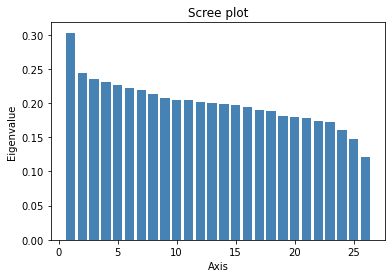

In [60]:
my_mca.plot_eigenvalues(type="absolute")

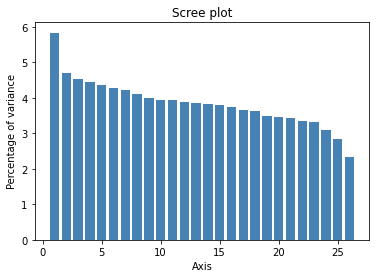

In [61]:
my_mca.plot_eigenvalues(type="percentage")

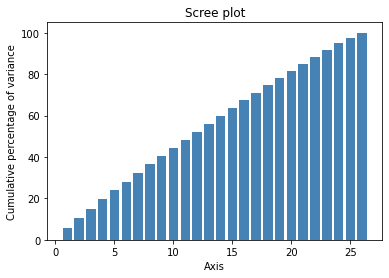

In [62]:
my_mca.plot_eigenvalues(type="cumulative")

In [63]:
df_rows = my_mca.row_topandas()

In [64]:
print(my_mca.row_coord_)

[[-0.68339073 -0.26805534 -0.81731075 ...  0.5901202   0.27572442
  -0.01250867]
 [-0.56681204 -0.05344139  0.27255564 ... -0.16227246 -0.0131766
   0.50571939]
 [-0.21238058  0.14689199  0.43766867 ...  0.07915116  0.33131787
  -0.3579329 ]
 ...
 [-0.03879018  0.02624114  0.53931864 ...  0.09739863 -0.31146822
  -0.35318323]
 [-0.10106492  0.05459412  0.39804232 ...  0.09105718 -0.23463955
  -0.23145907]
 [-0.06077792  0.30590769  0.36587306 ...  0.01396039 -0.47117557
  -0.59460039]]


In [65]:
print(my_mca.row_contrib_)

[[1.03000289e-02 1.96188249e-03 1.89919401e-02 ... 1.45337078e-02
  3.44808355e-03 8.60037391e-06]
 [7.08562894e-03 7.79793475e-05 2.11205514e-03 ... 1.09896807e-03
  7.87469614e-06 1.40576895e-02]
 [9.94786458e-04 5.89142453e-04 5.44610278e-03 ... 2.61462880e-04
  4.97871232e-03 7.04203167e-03]
 ...
 [3.31851489e-05 1.88013749e-05 8.26962409e-03 ... 3.95914270e-04
  4.40002157e-03 6.85638010e-03]
 [2.25268847e-04 8.13796559e-05 4.50457084e-03 ... 3.46038017e-04
  2.49706448e-03 2.94471413e-03]
 [8.14689061e-05 2.55508199e-03 3.80588605e-03 ... 8.13374619e-06
  1.00691509e-02 1.94332357e-02]]


In [66]:
print(my_mca.row_cos2_)

[[1.19223918e-01 1.83431598e-02 1.70529547e-01 ... 8.89009055e-02
  1.94077722e-02 3.99436557e-05]
 [1.10780891e-01 9.84786892e-04 2.56151596e-02 ... 9.07980123e-03
  5.98677883e-05 8.81872762e-02]
 [1.98551018e-02 9.49814479e-03 8.43205538e-02 ... 2.75776408e-03
  4.83205921e-02 5.63956701e-02]
 ...
 [4.74470197e-04 2.17135579e-04 9.17183641e-02 ... 2.99137693e-03
  3.05909479e-02 3.93337712e-02]
 [5.98839866e-03 1.74743742e-03 9.28898697e-02 ... 4.86114080e-03
  3.22784214e-02 3.14092989e-02]
 [1.02621626e-03 2.59972890e-02 3.71884564e-02 ... 5.41430156e-05
  6.16755199e-02 9.82194865e-02]]


In [67]:
df_cols = my_mca.col_topandas()

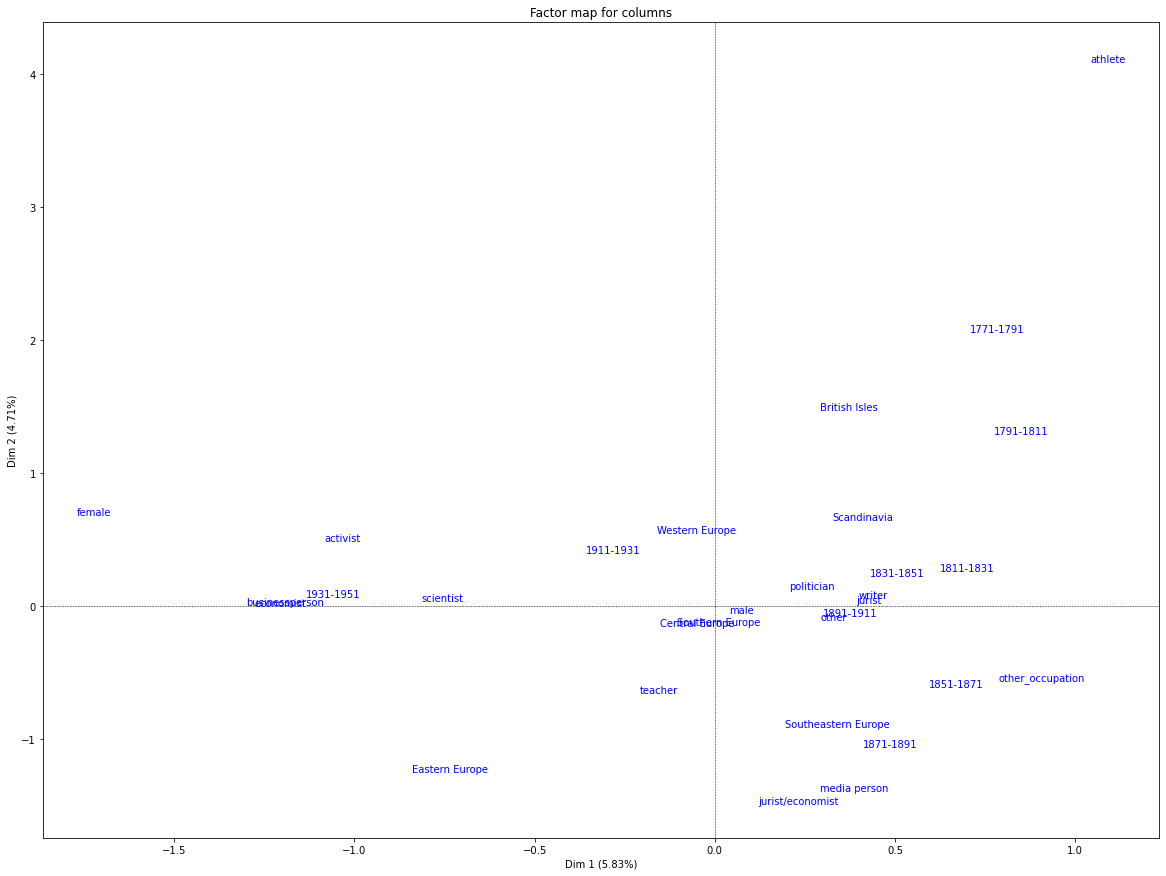

In [68]:
my_mca.mapping_col(num_x_axis=1, num_y_axis=2, figsize=(20, 15))

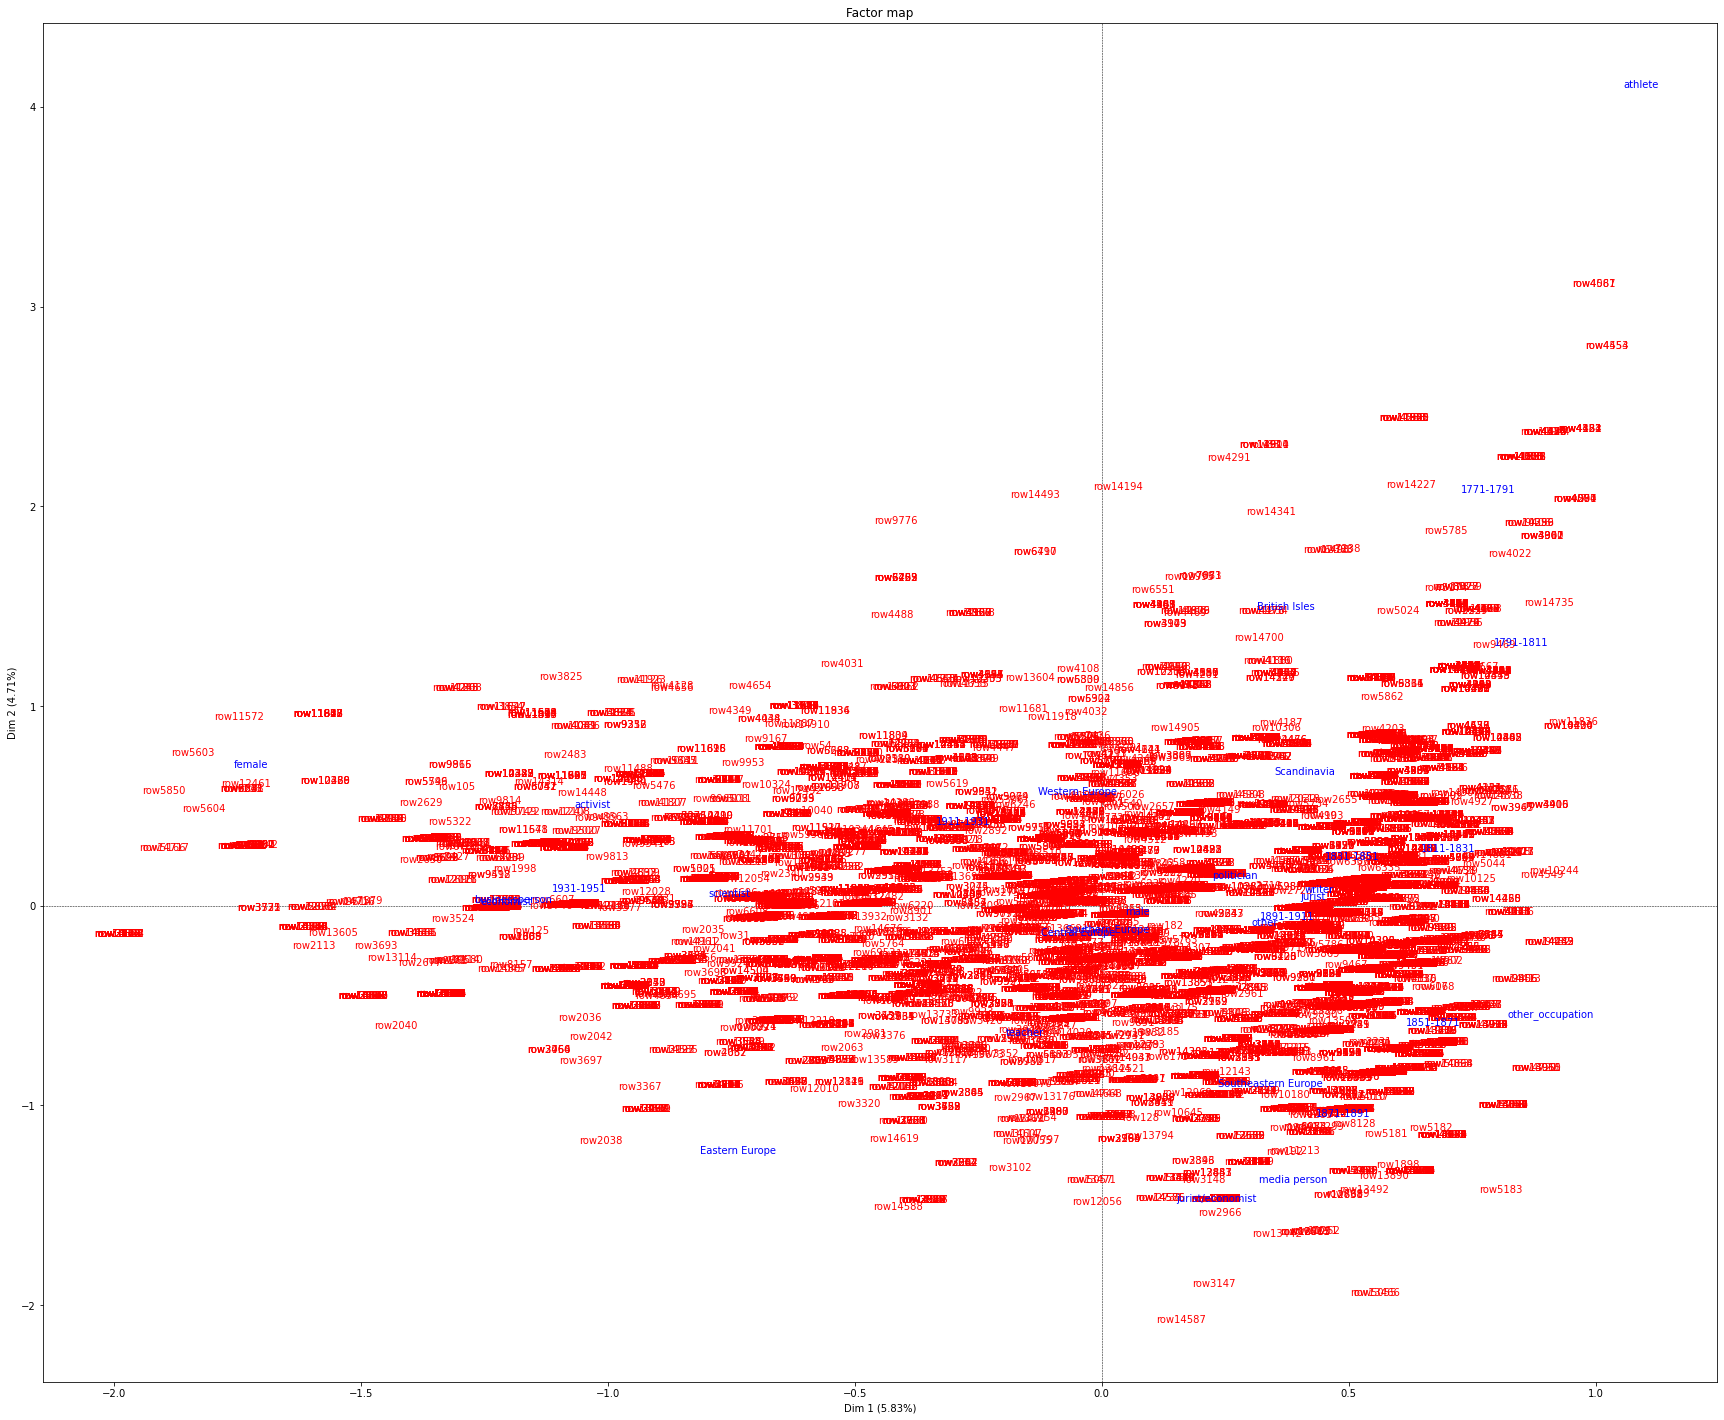

In [71]:
my_mca.mapping(num_x_axis=1, num_y_axis=2, short_labels="+", figsize=(30, 25))

In [2]:
my_mca.plot_col_contrib(num_axis=1, figsize=(15, 10) )

NameError: name 'my_mca' is not defined

In [3]:
import prince

In [4]:
 mca = prince.MCA(n_components=2, n_iter=3,copy=True, check_input=True, engine='auto',random_state=42)

In [5]:
D=pd.read_csv('spreadsheets/europe_MCA.csv', sep="|")

In [6]:
X=D[["type","gender","occupation","generation","region"]]
X

,type,gender,occupation,generation,region
0,economist,male,politician,1911-1931,Eastern Europe
1,economist,male,scientist,1891-1911,Central Europe
2,jurist,male,scientist,1911-1931,Central Europe
3,jurist,male,politician,1851-1871,British Isles
4,jurist,male,media person,1851-1871,British Isles
...,...,...,...,...,...
14956,jurist,male,businessperson,1931-1951,Southern Europe
14957,economist,male,politician,1931-1951,Southern Europe
14958,jurist,male,writer,1931-1951,Southern Europe
14959,jurist,male,politician,1931-1951,Southern Europe


In [7]:
mca = mca.fit(X)

In [14]:
print(pd.__version__)

1.1.3


AttributeError: 'PandasArray' object has no attribute '_str_split'

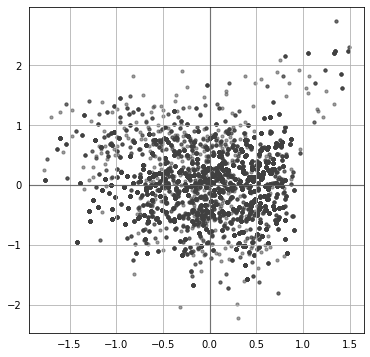

In [15]:
ax = mca.plot_coordinates(X=X, ax=None, figsize=(6, 6),
                         show_row_points=True, row_points_size=10,
                         row_points_alpha=0.5, show_row_labels=False,
                         show_column_points=True, column_points_size=30, show_column_labels=False,
                         legend_n_cols=5)